# MNIST Example

This notebook demonstrates how saliency maps are computed by various methods for smaller, not so massive neural networks based on the well-known `MNIST` data set. For a first glimpse onto the general workflow for using the *iNNvestigate* toolbox, or for users without access to beefy GPU or CPU hardware with tons of RAM, this is a good starting point.

# Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import numpy as np
import imp
import time

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis


eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


# Data
Then, the MNIST data is loaded in its entirety, formatted wrt to the specifications of the keras backend.

In [3]:
# Load data
channels_first = keras.backend.image_data_format() == "channels_first"
data = mnistutils.fetch_data(channels_first) #returns x_train, y_train, x_test, y_test as numpy.ndarray
num_classes = len(np.unique(data[1]))

# Test samples for illustrations
images = [(data[2][i].copy(), data[3][i]) for i in range(num_classes)]
label_to_class_name = [str(i) for i in range(num_classes)]

60000 train samples
10000 test samples


# Model
We have prepared a simple model configuration to play around with.

In [4]:
# Unpack model params by name. The line below currently selects an already pretrained network, which saves some time.
modelname = 'mlp_3dense'
activation_type = 'relu'
input_range = [-1, 1]
epochs = 20
batch_size = 128
create_model_kwargs = {'dense_units':1024, 'dropout_rate':0.25}

Now, preprocess the data wrt to the model's requirements, build the model and optionally train it for `epochs` epochs. 

In [5]:
# Preprocess data
data_preprocessed = (mnistutils.preprocess(data[0], input_range), data[1],
                     mnistutils.preprocess(data[2], input_range), data[3])


# Create & (optionally) train model
model, modelp = mnistutils.create_model(channels_first, modelname, **create_model_kwargs)
mnistutils.train_model(modelp, data_preprocessed, batch_size=batch_size, epochs=epochs)
model.set_weights(modelp.get_weights())

Epoch 1/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.3180 - acc: 0.9013
Epoch 2/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.1707 - acc: 0.9476
Epoch 3/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.1377 - acc: 0.9578
Epoch 4/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.1192 - acc: 0.9617
Epoch 5/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.1088 - acc: 0.9663
Epoch 6/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0992 - acc: 0.9682
Epoch 7/20
60000/60000 [==============================] - 3s 48us/step - loss: 0.0941 - acc: 0.9702
Epoch 8/20
60000/60000 [==============================] - 3s 49us/step - loss: 0.0852 - acc: 0.9733
Epoch 9/20
60000/60000 [==============================] - 3s 47us/step - loss: 0.0818 - acc: 0.9743
Epoch 10/20
60000/60000 [==============================] - 3s 50us/step - loss: 0.0783 - acc: 0.9750

# Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [6]:
# Determine analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS               POSTPROC FXN                TITLE

    # Show input
    ("input",                 {},                       mnistutils.image,          "Input"),

    # Function
    ("gradient",              {},                       mnistutils.graymap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      mnistutils.graymap,        "SmoothGrad"),
    ("integrated_gradients",  {},                       mnistutils.graymap,        "Integrated Gradients"),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    ("pattern.net",           {},                       mnistutils.bk_proj,        "PatternNet"),

    # Interaction
    ("lrp.z",                 {},                       mnistutils.heatmap,         "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,         "LRP-Epsilon"),
    ]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above and compute the analyses.

In [7]:
# Create analyzers.
analyzers = []
print('Creating analyzer instances. ')
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],   # analysis method identifier
                                            model,       # model without softmax output
                                            **method[1]) # optional analysis parameters
    # some analyzers require additional training. For those
    analyzer.fit(data_preprocessed[0],
                 pattern_type=activation_type,
                 batch_size=256, verbose=1)
    analyzers.append(analyzer)

print('Running analyses.')
# Apply analyzers to trained model.
analysis = np.zeros([len(images), len(analyzers), 28, 28, 3])
text = []
for i, (image, y) in enumerate(images):
    print('Image {}: '.format(i), end='')
    t_start = time.time()
    image = image[None, :, :, :]
    # Predict label.
    x = mnistutils.preprocess(image, input_range)
    presm = model.predict_on_batch(x)[0] #forward pass without softmax
    prob = modelp.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" %label_to_class_name[y],    # ground truth label
                 "%.2f" %presm.max(),             # pre-softmax logits
                 "%.2f" %prob.max(),              # probabilistic softmax output  
                 "%s" %label_to_class_name[y_hat] # predicted label
                ))
    
    for aidx, analyzer in enumerate(analyzers):
        # Measure execution time
        
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        a = analyzer.analyze(image if is_input_analyzer else x)
        
        # Postprocess.
        if not is_input_analyzer:
            a = mnistutils.postprocess(a)
        a = methods[aidx][2](a)
        analysis[i, aidx] = a[0]
    t_elapsed = time.time() - t_start
    print('{:.4f}s'.format(t_elapsed))

Creating analyzer instances. 
Epoch 1/1
235/235 [==============================] - 2s 8ms/step - loss: 3.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000
Running analyses.
Image 0: 3.8171s
Image 1: 0.0276s
Image 2: 0.0264s
Image 3: 0.0269s
Image 4: 0.0243s
Image 5: 0.0250s
Image 6: 0.0272s
Image 7: 0.0287s
Image 8: 0.0299s
Image 9: 0.0281s


You might have noticed that the analysis times for `Image 0` are substantially longer for all methods, compared to the follow-ups. Each analyzer manages a computational graph it attaches to the analyzed model. Upon first execution, the analyzer needs to build that graph, which can take some time. Each consecutive analysis on the same model though is almost instant.

Next, we visualize the analysis results.

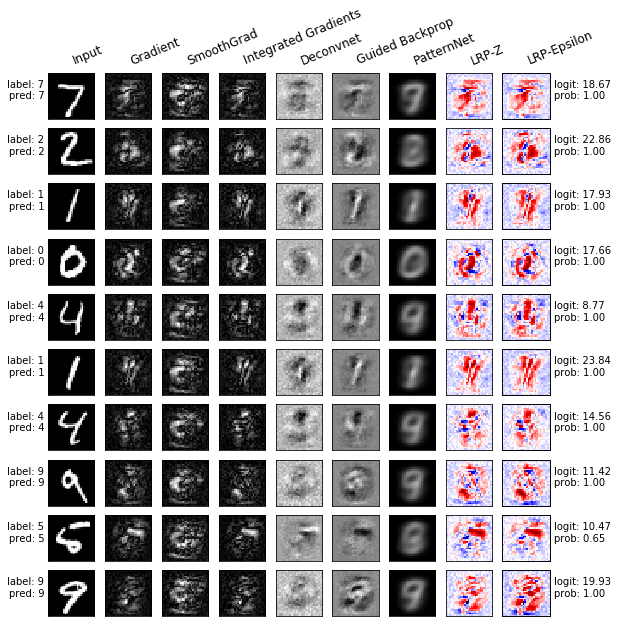

In [8]:
# Plot the analysis.
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels)

This figure shows the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).

If you are curious about how *iNNvestigate* performs on ImageNet models and data, [go here.](imagenet_example.ipynb)